In [6]:
import os

import cv2
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

from vedaseg.runners import InferenceRunner
from vedaseg.datasets import build_dataset
from vedaseg.transforms import build_transform
from pycocotools.coco import COCO

In [2]:
checkpoint = '/DATA/home/tianhewang/work_spaces/project_x-ray/xray_seg_ks0_lr004_150E/best_mIoU.pth'
nclasses = 2
ignore_label = 255
image_pad_value = (255, 255, 255)
size_h = 1153
size_w = 1345
dataset_type = 'XrayDataset'
dataset_root = ''
norm_cfg = dict(type='BN')
multi_label = True

img_norm_cfg = dict(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225),
                    max_pixel_value=255.0)
inference_cfg = dict(
    gpu_id='0, 1',
    multi_label=multi_label,
    transforms=[
        dict(type='LongestMaxSize',
             h_max=size_h,
             w_max=size_w,
             interpolation=cv2.INTER_LINEAR),
        dict(type='PadIfNeeded',
             min_height=size_h,
             min_width=size_w,
             value=image_pad_value,
             mask_value=ignore_label),
        dict(type='Normalize', **img_norm_cfg),
        dict(type='ToTensor'),
    ],
    model=dict(
        # model/encoder
        encoder=dict(
            backbone=dict(
                type='ResNet',
                arch='resnet50',
                replace_stride_with_dilation=[False, False, True],
                multi_grid=[1, 2, 4],
                norm_cfg=norm_cfg,
            ),
            enhance=dict(
                type='ASPP',
                from_layer='c5',
                to_layer='enhance',
                in_channels=2048,
                out_channels=256,
                atrous_rates=[6, 12, 18],
                mode='bilinear',
                align_corners=True,
                norm_cfg=norm_cfg,
                dropout=0.1,
            ),
        ),
        # model/decoder
        decoder=dict(
            type='GFPN',
            # model/decoder/blocks
            neck=[
                # model/decoder/blocks/block1
                dict(
                    type='JunctionBlock',
                    fusion_method='concat',
                    top_down=dict(
                        from_layer='enhance',
                        upsample=dict(
                            type='Upsample',
                            scale_factor=4,
                            scale_bias=-3,
                            mode='bilinear',
                            align_corners=True,
                        ),
                    ),
                    lateral=dict(
                        from_layer='c2',
                        type='ConvModule',
                        in_channels=256,
                        out_channels=48,
                        kernel_size=1,
                        norm_cfg=norm_cfg,
                        act_cfg=dict(type='Relu', inplace=True),
                    ),
                    post=None,
                    to_layer='p5',
                ),  # 4
            ],
        ),
        # model/head
        head=dict(
            type='Head',
            in_channels=304,
            inter_channels=256,
            out_channels=nclasses,
            norm_cfg=norm_cfg,
            num_convs=2,
            upsample=dict(
                type='Upsample',
                size=(size_h, size_w),
                mode='bilinear',
                align_corners=True,
            ),
        )))
common_cfg = dict(seed=0,
              logger=dict(handlers=(
                  dict(type='StreamHandler', level='INFO'),
                  dict(type='FileHandler', level='INFO'),
              ), ),
              cudnn_deterministic=False,
              cudnn_benchmark=True,
              metrics=[
                  dict(type='MultiLabelIoU', num_classes=nclasses),
                  dict(type='MultiLabelMIoU', num_classes=nclasses),
              ],
              dist_params=dict(backend='nccl'))
transform_cfg = [
                dict(type='LongestMaxSize', h_max=size_h, w_max=size_w,
                     interpolation=cv2.INTER_LINEAR),
                dict(type='PadIfNeeded', min_height=size_h, min_width=size_w,
                     value=image_pad_value, mask_value=0),
#                 dict(type='FactorScale', scale=1/16,
#                      interpolation=cv2.INTER_LINEAR,
#                      always_apply=True,
#                      p=1.0),
                # dict(type='GaussianBlur', blur_limit=7, p=0.5),
                dict(type='Normalize', **img_norm_cfg),
                dict(type='ToTensor'),
            ]
dataset_cfg=dict(
    type=dataset_type,
    root=dataset_root,
    ann_file='/DATA/home/tianhewang/DataSets/'
                         'KS_X-ray/ks_0/ks_0_train.json',
    img_prefix='',
    multi_label=multi_label)

transform = build_transform(transform_cfg)
dataset = build_dataset(dataset_cfg, dict(transform=transform))

runner = InferenceRunner(inference_cfg, common_cfg)
runner.load_checkpoint(checkpoint)


2020-10-16 11:29:07,048 - INFO - Set cudnn deterministic False
2020-10-16 11:29:07,049 - INFO - Set cudnn benchmark True
2020-10-16 11:29:07,049 - INFO - Build model
2020-10-16 11:29:07,851 - INFO - ResNet init weights from pretreain
2020-10-16 11:29:09,142 - INFO - ASPP init weights
2020-10-16 11:29:09,365 - INFO - GFPN init weights
2020-10-16 11:29:09,380 - INFO - Head init weights
2020-10-16 11:29:16,425 - INFO - Load checkpoint from /DATA/home/tianhewang/work_spaces/project_x-ray/xray_seg_ks0_lr004_150E/best_mIoU.pth


{'meta': {'best': OrderedDict([('mIoU', 0.668813592245145)]),
  'epoch': 87,
  'iter': 35670,
  'lr': array([0.01832248]),
  'time': 'Fri Oct 16 11:28:12 2020'},
 'state_dict': OrderedDict([('0.0.conv1.weight',
               tensor([[[[ 3.1392e-02,  4.5106e-03, -6.4923e-03,  ..., -1.1638e-02,
                          -9.8742e-03, -1.6873e-02],
                         [ 2.3434e-02, -3.7896e-03, -1.2214e-04,  ...,  2.6547e-03,
                          -2.1290e-03, -8.1143e-03],
                         [ 2.8348e-02,  1.2745e-03, -8.8741e-04,  ...,  3.7868e-02,
                           2.7995e-02,  2.4512e-02],
                         ...,
                         [ 2.9452e-02,  1.6065e-02,  9.2784e-04,  ..., -4.8645e-02,
                          -3.0404e-02,  2.9299e-03],
                         [ 2.9406e-02,  2.2868e-02,  2.8619e-02,  ...,  8.9155e-03,
                          -1.3495e-02, -6.5262e-03],
                         [-3.2877e-03, -9.6890e-03, -3.0084e-03,  ...,  1.

In [3]:
image_, mask_ = dataset[15]
image_ = image_.unsqueeze(0)
image_ = image_.cuda()
output = runner.model(image_)
output = output.sigmoid()
print(output.shape)
res = output.cpu().detach().numpy()
res = np.squeeze(res, axis=0)
print(res.shape)
clas_1 = res[0, ...].reshape(-1)
clas_2 = res[1, ...].reshape(-1)
print(max(clas_1), max(clas_1))

torch.Size([1, 2, 1153, 1345])
(2, 1153, 1345)
0.9999989 0.9999989


In [6]:
mask_ = mask_.astype(int)
mask1 = mask_[0, ...].reshape(-1)
mask2 = mask_[1, ...].reshape(-1)
print(max(mask1), max(mask2))

1 0


In [3]:
anno_file = '/DATA/home/tianhewang/DataSets/KS_X-ray/ks_0/ks_0_train.json'
ana_coco = COCO(anno_file)
keys = list(ana_coco.imgs.keys())
fn = ana_coco.imgs[keys[15]]['file_name']



def inverse_resize(pred, image_shape):
    h, w, _ = image_shape
    reisze_h, resized_w = pred.shape[0], pred.shape[1]
    scale_factor = max(h / reisze_h, w / resized_w)
    pred = cv2.resize(pred, (
        int(resized_w * scale_factor), int(reisze_h * scale_factor)),
                      interpolation=cv2.INTER_NEAREST)
    return pred


def inverse_pad(pred, image_shape):
    h, w, _ = image_shape
    return pred[:h, :w]

image = cv2.imread(fn)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w, c = image.shape
dummy_mask = np.zeros((h, w))
print(image.shape)
output = runner(image, [dummy_mask])
print(output.shape)
output = output.transpose((1, 2, 0))
print(output.shape)
output = inverse_resize(output, image.shape)
print(output.shape)
output = inverse_pad(output, image.shape)
print(output.shape)

(506, 675, 3)
(2, 1153, 1345)
(1153, 1345, 2)
(578, 674, 2)
(506, 674, 2)


(506, 674, 2)


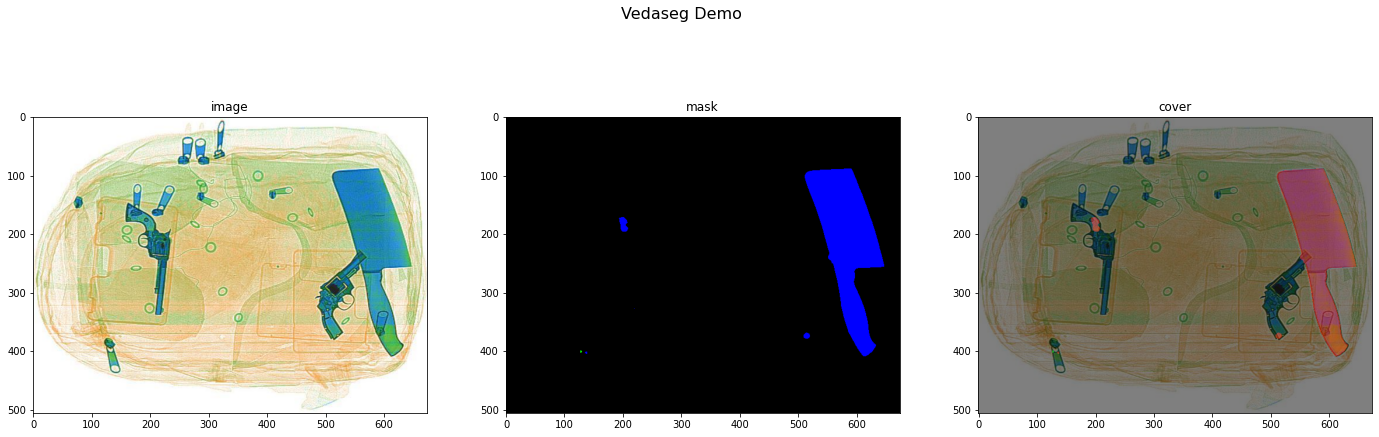

In [15]:
print(output.shape)

def plot_result(img, mask, cover):
    fig, ax = plt.subplots(1, 3, figsize=(24, 8))
    fig.suptitle("Vedaseg Demo", y=0.95, fontsize=16)

    ax[0].set_title('image')
    ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    ax[1].set_title(f'mask')
    ax[1].imshow(mask)

    ax[2].set_title(f'cover')
    ax[2].imshow(cv2.cvtColor(cover, cv2.COLOR_BGR2RGB))
    plt.show()


def result(fname,
           pred_mask,
           classes,
           multi_label=False,
           palette=None,
           show=False,
           out=None):
    if palette is None:
        palette = np.random.randint(0, 255, size=(len(classes), 3))
    else:
        palette = np.array(palette)
    img_ori = cv2.imread(fname)
    mask = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3), dtype=np.uint8)
    for label, color in enumerate(palette):
        if multi_label:
            mask[pred_mask[:, :, label] == 1] = color
        else:
            mask[pred_mask == label, :] = color
            
    img_ori = cv2.resize(img_ori, 
                         (pred_mask.shape[1], pred_mask.shape[0]),
                         interpolation=cv2.INTER_NEAREST)

    cover = img_ori * 0.5 + mask * 0.5
    cover = cover.astype(np.uint8)

    if out is not None:
        _, fullname = os.path.split(fname)
        fname, _ = os.path.splitext(fullname)
        save_dir = os.path.join(out, fname)
        os.makedirs(save_dir, exist_ok=True)
        cv2.imwrite(os.path.join(save_dir, 'img.png'), img_ori)
        cv2.imwrite(os.path.join(save_dir, 'mask.png'), mask)
        cv2.imwrite(os.path.join(save_dir, 'cover.png'), cover)
        if multi_label:
            for i in range(pred_mask.shape[-1]):
                cv2.imwrite(os.path.join(save_dir, classes[i] + '.png'),
                            pred_mask[:, :, i] * 255)

    if show:
        plot_result(img_ori, mask, cover)

result(fn, 
       output, 
       multi_label=multi_label,
       classes=('kn', 'sc'), 
       palette=[(0, 0, 255), (0, 255, 0)], 
       show=True,
       out=None)

In [ ]:
    def validate(self, dataloader, thresh=0.5):
        score_list = []
        label_list = []
        result_list = []
        with torch.no_grad():
            self.model.eval()
            for cnt, (img, label) in enumerate(dataloader):
                print('validate:{}/{} {}\r'.format(cnt, len(dataloader), img.shape), end='')
                img = img.cuda()
                result, score = self.infer(img)
                score_list.append(score)
                label = label.cpu().detach().numpy()
                result_list.append(result)
                label_list.append(label)

            result_list = np.vstack(result_list)
            label_list = np.vstack(label_list)
            score_list = np.vstack(score_list)
            acc = metrics.accuracy_score(label_list, result_list)
            AP = metrics.average_precision_score(label_list, score_list, average=None)
            mAP = metrics.average_precision_score(label_list, score_list)
            recall = metrics.precision_score(label_list, result_list, average=None)
            out_put1 = 'eval acc:{}, mAP:{}\n'.format(acc, mAP)
            out_put2 = 'AP:{}\n recall:{}\n'.format(AP, recall)
            print(out_put1)
            print(out_put2)
        return {'acc':acc, 'AP':AP, 'mAP':mAP, 'recall':recall}